In [1]:
#import libraries
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,StackingClassifier 
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

In [2]:
#load dataset
dataset= pd.read_excel("Output-table-prep.xlsx")

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1053 entries, 0 to 1052
Data columns (total 12 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   City                   1053 non-null   object
 1   State                  1053 non-null   object
 2   title                  1052 non-null   object
 3   supporters             1053 non-null   int64 
 4   raised                 1053 non-null   object
 5   needed                 1053 non-null   object
 6   posted_by              1053 non-null   object
 7   benefited_to           1053 non-null   object
 8   tax benifits           1053 non-null   object
 9   AboutBenefittedPerson  1053 non-null   object
 10  image                  1053 non-null   object
 11  genuine                1053 non-null   object
dtypes: int64(1), object(11)
memory usage: 98.8+ KB


In [4]:
dataset.describe()

,supporters
count,1053.000000
mean,126.347578
std,548.482596
min,1.000000
25%,4.000000
50%,23.000000
75%,87.000000
max,13724.000000


###  here the raised and needed column should be changed to numeric datatype

In [5]:
raised_amount  = []
for i in range(len(dataset['raised'])):
    if 'Rs' in dataset['raised'][i]:
        raised_amount.append(int(dataset['raised'][i][3:].replace(",","")))
    elif '$' in dataset['raised'][i]:
        raised_amount.append(int(dataset['raised'][i][1:].replace(",","")))

In [6]:
dataset['raised_amount'] = raised_amount

In [7]:
needed_amount = []
for i in range(len(dataset['needed'])):
    if '$' in dataset['needed'][i]:
        needed_amount.append(int(dataset['needed'][i][1:].replace(",","")))
    elif 'Rs' in dataset['needed'][i]:
        needed_amount.append(int(dataset['needed'][i][3:].replace(",","")))

In [8]:
dataset['needed_amount'] = needed_amount

In [9]:
dataset[['raised_amount','needed_amount']].dtypes

raised_amount    int64
needed_amount    int64
dtype: object

In [10]:
#dropping raised,needed column after conversion
dataset.drop(['raised','needed'],axis=1,inplace=True)

### check null values in the dataset 

In [11]:
dataset.isnull().sum()

City                     0
State                    0
title                    1
supporters               0
posted_by                0
benefited_to             0
tax benifits             0
AboutBenefittedPerson    0
image                    0
genuine                  0
raised_amount            0
needed_amount            0
dtype: int64

In [12]:
dataset['title'] = dataset['title'].fillna('unknown')

# Exploratory Data Analysis 

<AxesSubplot:xlabel='genuine', ylabel='count'>

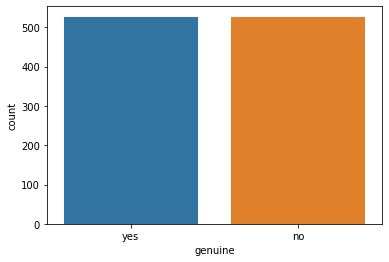

In [13]:
sns.countplot(data=dataset,x='genuine')

#### We have nearly equal no of labels in predictor attribute. so mostly the predictor attribute is balanced

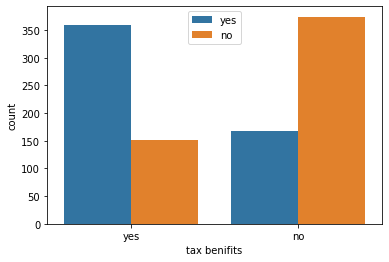

In [14]:
sns.countplot(data=dataset,x='tax benifits',hue='genuine')
plt.legend()

#### Here the fundraisers who don't have tax benifits are mostly not genuine 

<AxesSubplot:xlabel='supporters', ylabel='raised_amount'>

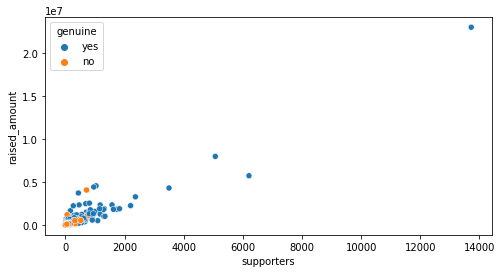

In [15]:
plt.figure(figsize=(8,4))
sns.scatterplot(y='raised_amount',x='supporters',data=dataset,hue='genuine')

#### Here we see a linear relationship between no of supporters and raised_amount 
#### Also can see that fundraiser who have gained people's trust is genuine 

<AxesSubplot:xlabel='raised_amount', ylabel='Density'>

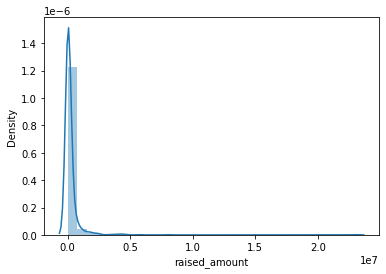

In [16]:
sns.distplot(dataset['raised_amount'],bins=30)

<AxesSubplot:xlabel='needed_amount', ylabel='Density'>

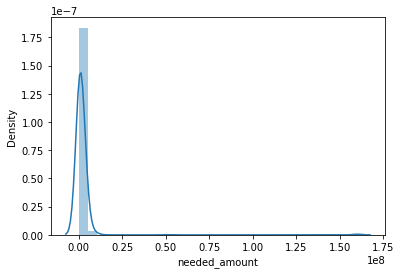

In [17]:
sns.distplot(dataset['needed_amount'],bins=30)

<AxesSubplot:xlabel='supporters', ylabel='Density'>

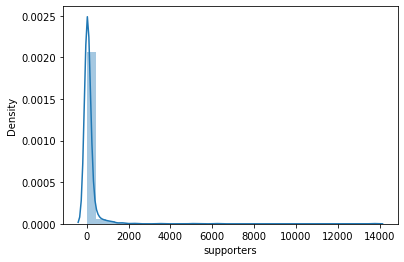

In [18]:
sns.distplot(dataset['supporters'],bins=30)

# Categorical features


In [19]:
low_cardinality_cols = [col for col in dataset.columns if dataset[col].nunique()<10 and dataset[col].dtype=="object"]
print(low_cardinality_cols)

['tax benifits', 'genuine']


In [20]:
high_cardinality_cols = [col for col in dataset.columns if dataset[col].nunique()>10 and dataset[col].dtype=="object"]
print(high_cardinality_cols)

['City', 'State', 'title', 'posted_by', 'benefited_to', 'AboutBenefittedPerson', 'image']


In [21]:
data = dataset.copy()

In [22]:
data[low_cardinality_cols] = pd.get_dummies(dataset[low_cardinality_cols],drop_first="True")

### Replace the state names with probabiltites w.r.t genuine column 

In [23]:
by_state = pd.DataFrame(dataset.groupby(['State','genuine']).count())
by_state.reset_index(inplace=True)

In [24]:
by_state = by_state.iloc[:,[0,1,2]]

In [25]:
state_values = dict(by_state.groupby('State').City.sum())

In [26]:
prob_by_state = [by_state['City'][i]/state_values[by_state['State'][i]] for i in range(len(by_state['State']))]   

In [27]:
by_state['prob_by_state'] = prob_by_state

In [28]:
by_state_no = by_state.loc[by_state['genuine']=='no']
by_state_yes = by_state.loc[by_state['genuine']=='yes']

In [29]:
x1 = list(by_state_yes['State'])
y1 = list(by_state_yes['prob_by_state'])
x2 = list(by_state_no['State'])
y2 = list(by_state_no['prob_by_state']) 

In [30]:
data_y = data.loc[data['genuine']==1]
data_y['State1'] = data_y['State'].replace(x1,y1)

In [31]:
data_n = data.loc[data['genuine']==0]
data_n['State1'] = data_n['State'].replace(x2,y2)

In [32]:
data = pd.concat([data_n,data_y])

In [33]:
def state(string):
    try:
        return abs(float(by_state_no.loc[by_state_no['State']==string]['prob_by_state'])-float(by_state_yes.loc[by_state_yes['State']==string]['prob_by_state']))
    except:
        return 0
    
data['statediff'] = data.State.map(state)

#### Tokenization — convert sentences to words
#### Removing unnecessary punctuation, tags Removing stop words — frequent words such as ”the”, ”is”, etc. that do not have specific semantic
#### Stemming — words are reduced to a root by removing inflection through dropping unnecessary characters, usually a suffix.
#### Lemmatization — Another approach to remove inflection by determining the part of speech and utilizing detailed database of the language.

In [34]:
import nltk
from nltk.tokenize import word_tokenize
titles = dataset.title.str.cat(sep=' ')

In [35]:
tokens = word_tokenize(titles)
vocabulary = set(tokens)
print(len(vocabulary))

1997


In [36]:
frequency_dist = nltk.FreqDist(tokens)
repeated_words = sorted(frequency_dist,key=frequency_dist.__getitem__, reverse=True)[0:75]

In [37]:
repeated_words = [i.upper() for i in repeated_words]

In [38]:
repeated_words_new = []

for i in range(len(repeated_words)):
    words = re.sub("[)!&,.''(]",'',repeated_words[i])
    repeated_words_new.append(words)
repeated_words = list(set(repeated_words_new))    

In [39]:
repeated_words.sort()
repeated_words = repeated_words[1:]

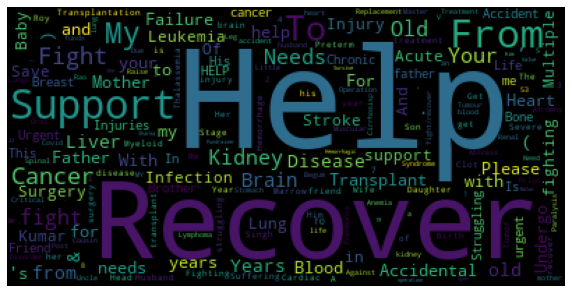

In [40]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
wordcloud = WordCloud()
wordcloud.generate_from_frequencies(frequency_dist)
plt.figure(figsize=(10,6))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Jaccard similairty

In [41]:
def regex_string(column_name):
    new_column = []
    string = ''
    for i in range(len(data[column_name])):
        string = re.sub("[!&',.0-9]",'',data[column_name][i].upper())
        string = re.sub(data['benefited_to'][0].upper(),"",string)
        string = re.sub(data['posted_by'][0].upper(),"",string)
        new_column.append(string)
    return new_column    

In [42]:
def jaccard(list1, list2):
    intersection = len(list(set(list1).intersection(list2)))
    union = (len(list1) + len(list2)) - intersection
    return np.round((intersection/union),4)

In [43]:
data['new_title'] = regex_string('title')

In [44]:
jaccard_sim = []
for i in range(len(data['title'])):
    jaccard_sim.append(jaccard(repeated_words,data['new_title'][i].split(" ")))

In [45]:
data['jaccard_title'] = jaccard_sim

### drop high cardinality cols

In [46]:
data1 = data.copy()

In [47]:
data1 = data.drop(high_cardinality_cols,axis=1)

In [48]:
data1.drop('new_title',axis=1,inplace=True)

## Handling numerical columns 

### For raised_amount,needed_amount column

In [49]:
data1['perc_collected'] =  data1['raised_amount']/data1['needed_amount'] 

In [50]:
def remove_outliers(dataset,column_name):
    Q1 = np.quantile(dataset[column_name],0.25)
    Q3 = np.quantile(dataset[column_name],0.75)
    IQR = Q3-Q1
    lower = Q1-1.5*IQR
    higher= Q3+1.5*IQR
    not_outliers = list(dataset[column_name].loc[(dataset[column_name]>lower) & (dataset[column_name]<higher)].index)
    dataset_new = dataset.iloc[not_outliers,:]
    return dataset_new

In [51]:
def make_quantiles(dataset,column_name):
    quantiles = list(np.quantile(dataset[column_name],[0,0.25,0.5,0.75,1]))
    return quantiles

In [52]:
def make_slab(data):
    if data>=quantiles[0] and data<quantiles[1]:
        return 1
    elif data>=quantiles[1] and data<quantiles[2]:
        return 2
    elif data>=quantiles[2] and data<quantiles[3]:
        return 3
    elif data>=quantiles[3] and data<quantiles[4]:
        return 4
    else:
        return 5

### supporters_slab

In [53]:
data_new = remove_outliers(data1,'supporters')
quantiles = make_quantiles(data_new,'supporters')
supporters_slab = data1.supporters.map(make_slab)
data1['supporters_slab'] = supporters_slab

In [54]:
quantiles

[1.0, 4.0, 23.0, 87.75, 13724.0]

### raised_slab

In [55]:
data_new = remove_outliers(data1,'raised_amount')
quantiles = make_quantiles(data_new,'raised_amount')
raised_slab =data1.raised_amount.map(make_slab)
data1['raised_slab'] = raised_slab

In [56]:
quantiles

[1.0, 2220.0, 20221.5, 121575.0, 23018313.0]

### needed_slab

In [57]:
data_new = remove_outliers(data1,'needed_amount')
quantiles = make_quantiles(data_new,'needed_amount')
needed_slab = data1.needed_amount.map(make_slab)
data1['needed_slab'] = needed_slab

In [58]:
quantiles

[5000.0, 380000.0, 800000.0, 1500000.0, 160000000.0]

### Split the data 

In [59]:
data1['tax benifits'] = data1['tax benifits'].astype('int64')
data1['genuine'] = data1['genuine'].astype('int64')

In [60]:
X = data1.drop(['genuine'],axis=1)
y = data1['genuine']


In [61]:
print(X.shape,y.shape)

(1053, 11) (1053,)


In [62]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42,stratify=y)

## Hyperparamter tuning using Randomsearchcv  

#### for Decisiontree

In [63]:
dt = DecisionTreeClassifier()
dt.fit(X_train,y_train)
preds = dt.predict(X_test)
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.76      0.82      0.79       174
           1       0.81      0.75      0.78       174

    accuracy                           0.78       348
   macro avg       0.79      0.78      0.78       348
weighted avg       0.79      0.78      0.78       348



In [64]:
DecisionTreeClassifier()


max_depth = [int(x) for x in np.linspace(10, 900,10)]

min_samples_split = [int(x) for x in np.linspace(2,100,1)]

min_samples_leaf = [int(x) for x in np.linspace(1,100,1)]

max_leaf_nodes = [int(x) for x in np.linspace(10, 900,10)]

ccp_alpha10         = [np.round(random.random()/10,4) for x in range(1,100)]
ccp_alpha100        = [np.round(random.random()/100,4) for x in range(1,100)]
ccp_alpha1000       = [np.round(random.random()/1000,4) for x in range(1,100)]

ccp_alpha           = ccp_alpha10+ccp_alpha100+ccp_alpha1000


random_grid = {'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              'criterion':['entropy','gini'],
              'ccp_alpha':ccp_alpha,
              'max_leaf_nodes':max_leaf_nodes}

In [65]:
dt1 = DecisionTreeClassifier()
dt_randomcv = RandomizedSearchCV(estimator=dt1,param_distributions=random_grid,n_jobs=-1)
dt_randomcv.fit(X_train,y_train)

RandomizedSearchCV(estimator=DecisionTreeClassifier(), n_jobs=-1,
                   param_distributions={'ccp_alpha': [0.0195, 0.0719, 0.0857,
                                                      0.0544, 0.0597, 0.0072,
                                                      0.0025, 0.0331, 0.0307,
                                                      0.019, 0.017, 0.0057,
                                                      0.0311, 0.0221, 0.0899,
                                                      0.0838, 0.096, 0.047,
                                                      0.0605, 0.0145, 0.0343,
                                                      0.021, 0.0114, 0.0437,
                                                      0.0801, 0.0323, 0.0177,
                                                      0.0881, 0.0736, 0.0561, ...],
                                        'criterion': ['entropy', 'gini'],
                                        'max_depth': [10, 108, 207, 306, 405,
                                                      504, 603, 702, 801, 900],
                                        'max_leaf_nodes': [10, 108, 207, 306,
                                                           405, 504, 603, 702,
                                                           801, 900],
                                        'min_samples_leaf': [1],
                                        'min_samples_split': [2]})

In [66]:
params_dt = dt_randomcv.best_params_
params_dt

{'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_leaf_nodes': 306,
 'max_depth': 504,
 'criterion': 'entropy',
 'ccp_alpha': 0.0022}

In [67]:
dt = DecisionTreeClassifier(min_samples_leaf=params_dt['min_samples_leaf'],
                            min_samples_split=params_dt['min_samples_split'],
                           max_leaf_nodes=params_dt['max_leaf_nodes'],
                           max_features=len(X_train.columns),
                           max_depth=params_dt['max_depth'],
                           criterion=params_dt['criterion'],
                           ccp_alpha=params_dt['ccp_alpha'])
dt.fit(X_train,y_train)
preds = dt.predict(X_test)
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86       174
           1       0.88      0.82      0.85       174

    accuracy                           0.85       348
   macro avg       0.85      0.85      0.85       348
weighted avg       0.85      0.85      0.85       348



#### for RandomForest

In [68]:
rf = RandomForestClassifier()
rf.fit(X_train,y_train)
preds = rf.predict(X_test)
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.79      0.83      0.81       174
           1       0.82      0.78      0.80       174

    accuracy                           0.80       348
   macro avg       0.80      0.80      0.80       348
weighted avg       0.80      0.80      0.80       348



In [69]:


n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1000, num = 10)]


max_depth = [int(x) for x in np.linspace(10, 900,10)]

min_samples_split = [int(x) for x in np.linspace(2,100,1)]

min_samples_leaf = [int(x) for x in np.linspace(1,100,1)]

ccp_alpha10         = [np.round(random.random()/10,4) for x in range(1,100)]
ccp_alpha100        = [np.round(random.random()/100,4) for x in range(1,100)]
ccp_alpha1000       = [np.round(random.random()/1000,4) for x in range(1,100)]

ccp_alpha           = ccp_alpha10+ccp_alpha100+ccp_alpha1000

class_weight     = ['balanced','balanced_subsample']

random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              'criterion':['entropy','gini'],
              'ccp_alpha':ccp_alpha,
              'class_weight':class_weight}

In [70]:
rf1 = RandomForestClassifier()
rf_randomcv = RandomizedSearchCV(estimator=rf1,param_distributions=random_grid,n_jobs=-1)
rf_randomcv.fit(X_train,y_train)

RandomizedSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'ccp_alpha': [0.0041, 0.0775, 0.0231,
                                                      0.0692, 0.0673, 0.0206,
                                                      0.0439, 0.0889, 0.0083,
                                                      0.0234, 0.0035, 0.0271,
                                                      0.0592, 0.0448, 0.0576,
                                                      0.0564, 0.0863, 0.0465,
                                                      0.0231, 0.0167, 0.0309,
                                                      0.0007, 0.0782, 0.0703,
                                                      0.0502, 0.0085, 0.0135,
                                                      0.081, 0.0833, 0.0948, ...],
                                        'class_weight': ['balanced',
                                                         'balanced_subsample'],
                                        'criterion': ['entropy', 'gini'],
                                        'max_depth': [10, 108, 207, 306, 405,
                                                      504, 603, 702, 801, 900],
                                        'min_samples_leaf': [1],
                                        'min_samples_split': [2],
                                        'n_estimators': [200, 288, 377, 466,
                                                         555, 644, 733, 822,
                                                         911, 1000]})

In [71]:
params = rf_randomcv.best_params_

In [72]:
rf = RandomForestClassifier(n_estimators=params['n_estimators'],min_samples_split= params['min_samples_split'],
                            min_samples_leaf= params['min_samples_leaf'],
                            max_features=len(X_train.columns),
                            criterion=params['criterion'],max_depth=params['max_depth'],
                           class_weight=params['class_weight'],ccp_alpha=params['ccp_alpha'])
rf.fit(X_train,y_train)
preds = rf.predict(X_test)
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.90      0.87      0.88       174
           1       0.87      0.90      0.89       174

    accuracy                           0.89       348
   macro avg       0.89      0.89      0.89       348
weighted avg       0.89      0.89      0.89       348



#### for adaboost

In [73]:
adb = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1))
adb.fit(X_train,y_train)
preds = adb.predict(X_test)
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.94      0.93      0.93       174
           1       0.93      0.94      0.93       174

    accuracy                           0.93       348
   macro avg       0.93      0.93      0.93       348
weighted avg       0.93      0.93      0.93       348



In [74]:
alpha10         = [np.round(random.random()/10,4) for x in range(1,100)]
alpha100        = [np.round(random.random()/100,4) for x in range(1,100)]
alpha1000       = [np.round(random.random()/1000,4) for x in range(1,100)]

learning_rate = alpha10+alpha100+alpha1000
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 2000, num = 10)]

random_grid = {'learning_rate':learning_rate,
              'n_estimators':n_estimators,
              'algorithm':['SAMME','SAMME.R']}

In [75]:
adb1 = AdaBoostClassifier()
ada_randomcv = RandomizedSearchCV(estimator=adb1,param_distributions=random_grid,n_jobs=-1)

In [76]:
ada_randomcv.fit(X_train,y_train)

RandomizedSearchCV(estimator=AdaBoostClassifier(), n_jobs=-1,
                   param_distributions={'algorithm': ['SAMME', 'SAMME.R'],
                                        'learning_rate': [0.0745, 0.083, 0.0746,
                                                          0.0531, 0.0313,
                                                          0.0429, 0.0795,
                                                          0.0214, 0.0888,
                                                          0.0302, 0.0665,
                                                          0.0606, 0.0239,
                                                          0.0307, 0.0379,
                                                          0.0976, 0.0796,
                                                          0.0084, 0.0139,
                                                          0.0042, 0.0512,
                                                          0.0841, 0.0006,
                                                          0.0657, 0.0841,
                                                          0.0409, 0.0245,
                                                          0.0827, 0.0819,
                                                          0.0731, ...],
                                        'n_estimators': [10, 231, 452, 673, 894,
                                                         1115, 1336, 1557, 1778,
                                                         2000]})

In [77]:
params_adb = ada_randomcv.best_params_
params_adb

{'n_estimators': 1336, 'learning_rate': 0.0124, 'algorithm': 'SAMME.R'}

In [78]:
adbr = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(min_samples_leaf=params_dt['min_samples_leaf'],
                            min_samples_split=params_dt['min_samples_split'],
                           max_leaf_nodes=params_dt['max_leaf_nodes'],
                           max_features=len(X_train.columns),
                           max_depth=params_dt['max_depth'],
                           criterion=params_dt['criterion'],
                           ccp_alpha=params_dt['ccp_alpha'])
                          ,n_estimators=params_adb['n_estimators'],
                           learning_rate=params_adb['learning_rate'],
                           algorithm=params_adb['algorithm'])
adbr.fit(X_train,y_train)
preds = adbr.predict(X_test)
print(classification_report(y_test,preds))

              precision    recall  f1-score   support

           0       0.83      0.88      0.85       174
           1       0.87      0.82      0.84       174

    accuracy                           0.85       348
   macro avg       0.85      0.85      0.85       348
weighted avg       0.85      0.85      0.85       348



In [79]:
level0 = [('dt_classifier',DecisionTreeClassifier(min_samples_leaf=params_dt['min_samples_leaf'],
                            min_samples_split=params_dt['min_samples_split'],
                           max_leaf_nodes=params_dt['max_leaf_nodes'],
                           max_features=len(X_train.columns),
                           max_depth=params_dt['max_depth'],
                           criterion=params_dt['criterion'],
                           ccp_alpha=params_dt['ccp_alpha'])),
          ('rf_classifier', RandomForestClassifier(n_estimators=params['n_estimators'],
                                                   min_samples_split= params['min_samples_split'],
                                                   min_samples_leaf= params['min_samples_leaf'],
                                                   max_features=len(X_train.columns),
                                                   criterion=params['criterion'],
                                                   max_depth=params['max_depth'],
                                                   class_weight=params['class_weight'],
                                                   ccp_alpha=params['ccp_alpha'])),
          ('ad_classifier',AdaBoostClassifier(base_estimator=DecisionTreeClassifier(
              min_samples_leaf=params_dt['min_samples_leaf'],
                            min_samples_split=params_dt['min_samples_split'],
                           max_leaf_nodes=params_dt['max_leaf_nodes'],
                           max_features=len(X_train.columns),
                           max_depth=params_dt['max_depth'],
                           criterion=params_dt['criterion'],
                           ccp_alpha=params_dt['ccp_alpha'])
                          ,n_estimators=params_adb['n_estimators'],
                           learning_rate=params_adb['learning_rate'],
                           algorithm=params_adb['algorithm']))]

level1 = LogisticRegression()


model = StackingClassifier(estimators=level0,final_estimator=level1,n_jobs=-1)


In [80]:
model.fit(X_train,y_train)
y_preds = model.predict(X_test)

In [81]:
print(confusion_matrix(y_test,y_preds))
print(accuracy_score(y_test,y_preds))

[[155  19]
 [ 15 159]]
0.9022988505747126


In [82]:
print(classification_report(y_test,y_preds))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       174
           1       0.89      0.91      0.90       174

    accuracy                           0.90       348
   macro avg       0.90      0.90      0.90       348
weighted avg       0.90      0.90      0.90       348



In [83]:
x = [3,0,600,500000,0.581699,0.16339,0.065600,0.001200,1,1,2]

In [84]:
x = np.reshape(x,(1,-1))
#model.predict(x)

In [85]:
filename = 'modellib.sav'

In [86]:
joblib.dump(model, filename)
 

['modellib.sav']

In [87]:
loaded_model = joblib.load(filename)

In [88]:
preds = loaded_model.predict_proba(x)

In [89]:
preds[0]

array([0.94695613, 0.05304387])

In [90]:
x1 = loaded_model.predict_proba(x)

In [91]:
x1

array([[0.94695613, 0.05304387]])

In [92]:
x1.tolist()[0][0]

0.9469561330261844